<a href="https://colab.research.google.com/github/tameemglewo/Intrusion-Detection-System-using-Machine-Learning/blob/main/Multi_Class_Intrusion_Detection_System_Using_XGBoost.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
"""
Multi-Class Attack Classifier
This script processes the CIC-IDS2017 dataset to classify the specific type
of network attack, after excluding all benign traffic.
"""

import pandas as pd
import numpy as np
from google.colab import drive
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.model_selection import StratifiedShuffleSplit, train_test_split
from sklearn.neighbors import LocalOutlierFactor
from imblearn.over_sampling import SMOTE
from collections import Counter
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report, confusion_matrix
from xgboost import XGBClassifier
import time

# --- Mount Google Drive ---
try:
    drive.mount('/content/drive', force_remount=True)
except Exception as e:
    print(f"Error mounting drive: {e}")

# --- 1. Data Loading and Initial Cleaning ---
print("\n--- Loading Data ---")
data_dir = '/content/drive/MyDrive/CICIDS2017_Parquet/'

if not os.path.exists(data_dir):
    print(f"Error: Directory not found at {data_dir}. Please check your Google Drive path.")
    exit()

print("Loading and concatenating Parquet files...")
all_parquet_files = [os.path.join(data_dir, f) for f in os.listdir(data_dir) if f.endswith('.parquet')]
dfs = [pd.read_parquet(file) for file in all_parquet_files]
full_dataset = pd.concat(dfs, ignore_index=True)
print(f"Full dataset loaded. Initial shape: {full_dataset.shape}")

# Basic Cleaning
# --- Track and report the number of cleaned rows ---
print("\n--- Cleaning Data ---")
initial_rows = full_dataset.shape[0]

# Strip column names
full_dataset.columns = full_dataset.columns.str.strip()

# Handle infinite values
full_dataset.replace([np.inf, -np.inf], np.nan, inplace=True)
rows_before_na_drop = full_dataset.shape[0]
full_dataset.dropna(inplace=True)
rows_after_na_drop = full_dataset.shape[0]
print(f"Removed {rows_before_na_drop - rows_after_na_drop} rows with NaN or infinite values.")

# Handle duplicate rows
rows_before_dup_drop = full_dataset.shape[0]
full_dataset.drop_duplicates(inplace=True)
rows_after_dup_drop = full_dataset.shape[0]
print(f"Removed {rows_before_dup_drop - rows_after_dup_drop} duplicate rows.")

# Handle single-value columns
columns_to_drop_single_value = [col for col in full_dataset.columns if full_dataset[col].nunique() <= 1]
if columns_to_drop_single_value:
    full_dataset.drop(columns=columns_to_drop_single_value, inplace=True)
    print(f"Removed {len(columns_to_drop_single_value)} columns with a single unique value.")

final_rows = full_dataset.shape[0]
print(f"\nTotal rows cleaned: {initial_rows - final_rows}")
print(f"Dataset cleaned. Final shape: {full_dataset.shape}")

Mounted at /content/drive

--- Loading Data ---
Loading and concatenating Parquet files...
Full dataset loaded. Initial shape: (2313810, 78)

--- Cleaning Data ---
Removed 0 rows with NaN or infinite values.
Removed 82004 duplicate rows.
Removed 8 columns with a single unique value.

Total rows cleaned: 82004
Dataset cleaned. Final shape: (2231806, 70)


In [ ]:
# --- 2. Prepare Data for Attack-Only Classification ---
print("\n--- Preparing Data for Multi-Class Attack Classification ---")

# Filter out 'Benign' traffic
# Create a copy that only contains attack data.
# The label might be 'Benign' or 'BENIGN'. We check for both.
attack_df = full_dataset[~full_dataset['Label'].str.contains('Benign', case=False)].copy()

if attack_df.empty:
    print("Error: No attack data found after filtering.")
    exit()

# *** MODIFICATION: Consolidate all web attack types into a single category ***
print("\nConsolidating web attack categories...")
attack_df['Label'] = attack_df['Label'].replace({
    'Web Attack � XSS': 'Web Attack',
    'Web Attack � Sql Injection': 'Web Attack',
    'Web Attack � Brute Force': 'Web Attack'
})
print("Web attacks consolidated.")

print(f"Filtered out benign traffic. Remaining data shape: {attack_df.shape}")
print("\nDistribution of remaining traffic (attack types):")
print(attack_df['Label'].value_counts())


--- Preparing Data for Multi-Class Attack Classification ---

Consolidating web attack categories...
Web attacks consolidated.
Filtered out benign traffic. Remaining data shape: (336492, 70)

Distribution of remaining traffic (attack types):
Label
DoS Hulk            172846
DDoS                128014
DoS GoldenEye        10286
FTP-Patator           5931
DoS slowloris         5385
DoS Slowhttptest      5228
SSH-Patator           3219
Web Attack            2143
PortScan              1956
Bot                   1437
Infiltration            36
Heartbleed              11
Name: count, dtype: int64


In [ ]:
# --- 3. Feature Engineering and Label Encoding for Attacks ---
# Use LabelEncoder to convert string attack labels to integers
label_encoder = LabelEncoder()
attack_df['Label_Encoded'] = label_encoder.fit_transform(attack_df['Label'])

# Store the mapping for later interpretation
num_classes = len(label_encoder.classes_)
print(f"\nEncoded {num_classes} attack types into numerical format.")
print("Attack Class to integer mapping:")
for i, class_name in enumerate(label_encoder.classes_):
    print(f"  '{class_name}': {i}")

# Separate features (X) from the encoded label (y)
X = attack_df.drop(['Label', 'Label_Encoded'], axis=1)
y = attack_df['Label_Encoded']

# Apply Min-Max Scaling to numerical features
numerical_cols = X.select_dtypes(include=np.number).columns.tolist()
scaler = MinMaxScaler()
X_scaled = X.copy()
X_scaled[numerical_cols] = scaler.fit_transform(X_scaled[numerical_cols])
print("\nNumerical features scaled using MinMaxScaler.")


Encoded 12 attack types into numerical format.
Attack Class to integer mapping:
  'Bot': 0
  'DDoS': 1
  'DoS GoldenEye': 2
  'DoS Hulk': 3
  'DoS Slowhttptest': 4
  'DoS slowloris': 5
  'FTP-Patator': 6
  'Heartbleed': 7
  'Infiltration': 8
  'PortScan': 9
  'SSH-Patator': 10
  'Web Attack': 11

Numerical features scaled using MinMaxScaler.


In [ ]:
# --- 4. Stratified Sampling ---
# We sample a fraction of the data to make training manageable.
target_sample_size = 200000 # Adjusted sample size for the smaller dataset
if len(X_scaled) > target_sample_size:
    print(f"\n--- Performing Stratified Sampling to get {target_sample_size} samples ---")
    sss = StratifiedShuffleSplit(n_splits=1, train_size=target_sample_size, random_state=42)
    for train_index, _ in sss.split(X_scaled, y):
        X_sampled = X_scaled.iloc[train_index]
        y_sampled = y.iloc[train_index]
    print(f"Sampling complete. Sampled data shape: {X_sampled.shape}")
    # MODIFICATION: Show class distribution after sampling
    print(f"\nClass distribution AFTER stratified sampling:\n{y_sampled.value_counts().sort_index()}")
else:
    print("\nDataset is smaller than target sample size, skipping sampling.")
    X_sampled = X_scaled
    y_sampled = y


--- Performing Stratified Sampling to get 200000 samples ---
Sampling complete. Sampled data shape: (200000, 69)

Class distribution AFTER stratified sampling:
Label_Encoded
0        854
1      76087
2       6114
3     102734
4       3107
5       3201
6       3525
7          7
8         21
9       1163
10      1913
11      1274
Name: count, dtype: int64


In [ ]:
# --- 5. Outlier Detection ---
# *** MODIFICATION: Implemented robust outlier detection to preserve rare classes ***
print("\n--- Starting Intelligent Outlier Removal using LOF ---")
# Define a threshold for rare classes (do not apply LOF to these)
RARE_CLASS_THRESHOLD = 100
class_counts = y_sampled.value_counts()
majority_classes = class_counts[class_counts >= RARE_CLASS_THRESHOLD].index
minority_classes = class_counts[class_counts < RARE_CLASS_THRESHOLD].index

# Separate majority and minority data
X_majority = X_sampled[y_sampled.isin(majority_classes)]
y_majority = y_sampled[y_sampled.isin(majority_classes)]
X_minority = X_sampled[y_sampled.isin(minority_classes)]
y_minority = y_sampled[y_sampled.isin(minority_classes)]

print(f"Separated data: {len(X_majority)} majority samples, {len(X_minority)} rare minority samples.")

# Apply LOF only to the majority class data
lof = LocalOutlierFactor(n_neighbors=20, contamination=0.05, n_jobs=-1)
outlier_predictions = lof.fit_predict(X_majority)
X_majority_cleaned = X_majority[outlier_predictions == 1]
y_majority_cleaned = y_majority[outlier_predictions == 1]
print(f"Removed {(outlier_predictions == -1).sum()} outliers.")

# Recombine the cleaned majority data with the untouched minority data
X_cleaned = pd.concat([X_majority_cleaned, X_minority]).reset_index(drop=True)
y_cleaned = pd.concat([y_majority_cleaned, y_minority]).reset_index(drop=True)
print(f"Final Features shape after intelligent LOF: {X_cleaned.shape}")
print(f"Final class distribution BEFORE SPLIT:\n{y_cleaned.value_counts().sort_index()}")


--- Starting Intelligent Outlier Removal using LOF ---
Separated data: 199972 majority samples, 28 rare minority samples.
Removed 9999 outliers.
Final Features shape after intelligent LOF: (190001, 69)
Final class distribution BEFORE SPLIT:
Label_Encoded
0       727
1     74364
2      5533
3     96138
4      2859
5      2906
6      3351
7         7
8        21
9      1057
10     1825
11     1213
Name: count, dtype: int64


In [ ]:
# --- 6. Preparing Data for Multi-Class Model ---
# Using standard stratified split now that we've protected the rare classes
print(f"Final class distribution BEFORE SPLIT:\n{y_cleaned.value_counts().sort_index()}")
X_train, X_test, y_train, y_test = train_test_split(
    X_cleaned, y_cleaned, test_size=0.3, random_state=42, stratify=y_cleaned
)
print("\n--- Standard Stratified Train-Test Split Complete ---")

# Check shapes before and after SMOTE ---
print("\n--- Handling Class Imbalance (SMOTE) on Training Data ---")
print(f"\nShape of training data BEFORE SMOTE: X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"Class distribution AFTER SPLIT & BEFORE SMOTE:\n{y_train.value_counts().sort_index()}")

# --- 7. Applying SMOTE on Training Data ---
min_train_class_count = y_train.value_counts().min()
if min_train_class_count > 1:
    smote = SMOTE(random_state=42, k_neighbors=min_train_class_count - 1)
    X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)
    print("\nSMOTE applied successfully.")
    print(f"\nShape of training data AFTER SMOTE: X_train_resampled: {X_train_resampled.shape}, y_train_resampled: {y_train_resampled.shape}")
    print(f"Class distribution AFTER SMOTE:\n{pd.Series(y_train_resampled).value_counts().sort_index()}")
else:
    print("\nCannot apply SMOTE, at least one class has only 1 sample. Training on imbalanced data.")
    X_train_resampled, y_train_resampled = X_train, y_train

Final class distribution BEFORE SPLIT:
Label_Encoded
0       727
1     74364
2      5533
3     96138
4      2859
5      2906
6      3351
7         7
8        21
9      1057
10     1825
11     1213
Name: count, dtype: int64

--- Standard Stratified Train-Test Split Complete ---

--- Handling Class Imbalance (SMOTE) on Training Data ---

Shape of training data BEFORE SMOTE: X_train: (133000, 69), y_train: (133000,)
Class distribution AFTER SPLIT & BEFORE SMOTE:
Label_Encoded
0       509
1     52055
2      3873
3     67296
4      2001
5      2034
6      2346
7         5
8        15
9       740
10     1277
11      849
Name: count, dtype: int64

SMOTE applied successfully.

Shape of training data AFTER SMOTE: X_train_resampled: (807552, 69), y_train_resampled: (807552,)
Class distribution AFTER SMOTE:
Label_Encoded
0     67296
1     67296
2     67296
3     67296
4     67296
5     67296
6     67296
7     67296
8     67296
9     67296
10    67296
11    67296
Name: count, dtype: int64


In [ ]:
# --- 8. Building and Training the XGBoost Model for Attacks ---
print("\n\n--- Builduing the XGBoost Classifier ---")

y_train_np = y_train_resampled.values
y_test_np = y_test.values

# XGBoost works directly with NumPy arrays or pandas DataFrames
# It's good practice to use the .values to ensure a consistent NumPy format
#  Train XGBoost Model
xgb_model = XGBClassifier(
    objective='multi:softmax',   # For multi-class classification
    num_class=len(label_encoder.classes_),
    eval_metric='mlogloss',      # Logloss for multi-class
    use_label_encoder=False,
    random_state=42
)
# Train the model on the same SMOTE-balanced data
print("Training XGBoost model...")
start_time = time.time()
xgb_model.fit(X_train_resampled.values, y_train_resampled.values)
end_time = time.time()
print("XGBoost model training complete.")
print(f"Training time: {end_time - start_time:.2f} seconds")



--- Builduing the XGBoost Classifier ---
Training XGBoost model...
XGBoost model training complete.
Training time: 289.95 seconds



--- XGBoost Model Evaluation on Test Set ---
Test Accuracy: 0.9992

--- XGBoost Classification Report ---
                  precision    recall  f1-score   support

             Bot    1.00000   1.00000   1.00000       218
            DDoS    1.00000   1.00000   1.00000     22309
   DoS GoldenEye    0.99282   0.99940   0.99610      1660
        DoS Hulk    0.99986   0.99889   0.99938     28842
DoS Slowhttptest    0.99534   0.99534   0.99534       858
   DoS slowloris    0.99427   0.99541   0.99484       872
     FTP-Patator    1.00000   1.00000   1.00000      1005
      Heartbleed    1.00000   1.00000   1.00000         2
    Infiltration    1.00000   1.00000   1.00000         6
        PortScan    0.94012   0.99054   0.96467       317
     SSH-Patator    0.99818   0.99818   0.99818       548
      Web Attack    0.99449   0.99176   0.99312       364

        accuracy                        0.99916     57001
       macro avg    0.99292   0.99746   0.99514     57001
    weighted avg    0

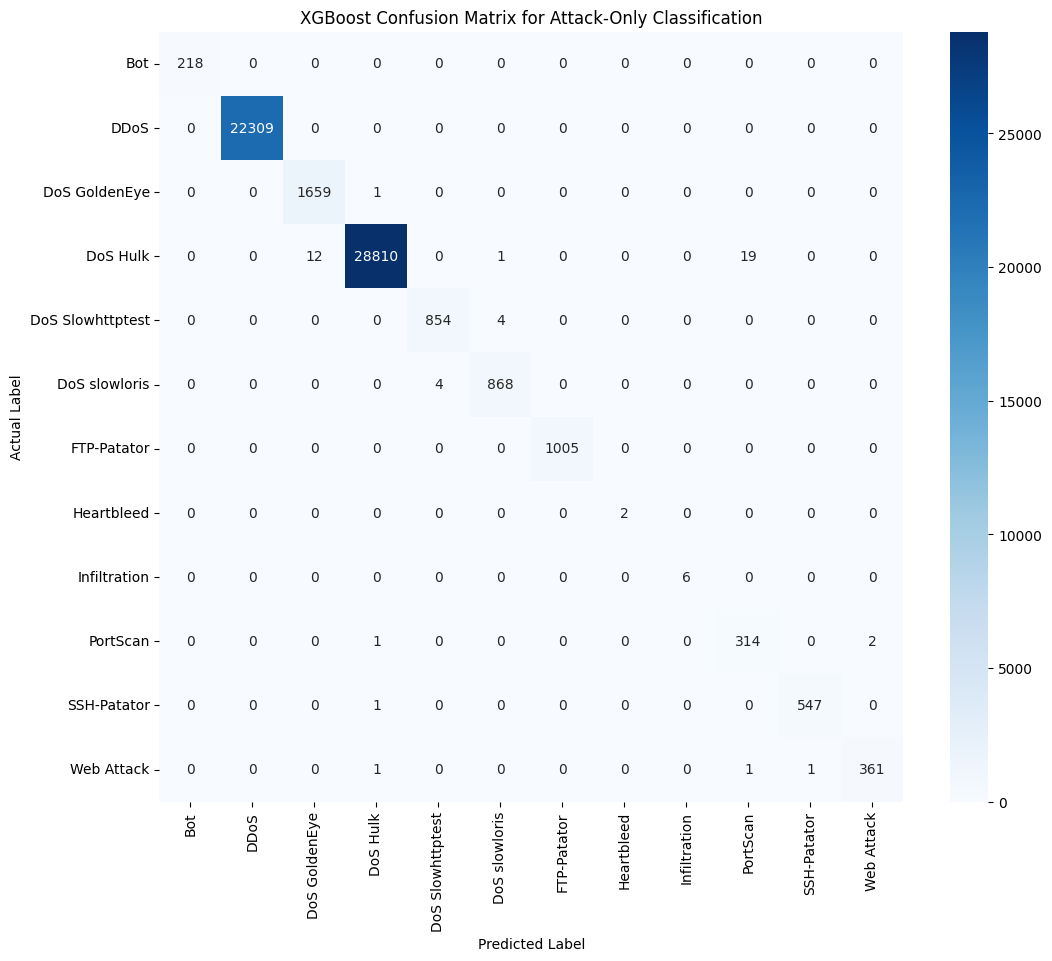

In [ ]:
# --- 9. Evaluating the Attack Classifier ---
print("\n--- XGBoost Model Evaluation on Test Set ---")

# Make predictions on the original, untouched test set
y_pred_classes_xgb = xgb_model.predict(X_test.values)

# Calculate accuracy
accuracy_xgb = np.mean(y_test_np == y_pred_classes_xgb)
print(f"Test Accuracy: {accuracy_xgb:.4f}")

print("\n--- XGBoost Classification Report ---")
present_labels_xgb = np.unique(np.concatenate((y_test_np, y_pred_classes_xgb)))
report_target_names_xgb = [name for i, name in enumerate(label_encoder.classes_) if i in present_labels_xgb]
print(classification_report(
    y_test_np,
    y_pred_classes_xgb,
    labels=present_labels_xgb,
    target_names=report_target_names_xgb,
    zero_division=0,
    digits=5
))

# --- XGBoost Confusion Matrix ---
cm_xgb = confusion_matrix(y_test_np, y_pred_classes_xgb, labels=present_labels_xgb)
plt.figure(figsize=(12, 10))
sns.heatmap(cm_xgb, annot=True, fmt='d', cmap='Blues',
            xticklabels=report_target_names_xgb,
            yticklabels=report_target_names_xgb)
plt.title('XGBoost Confusion Matrix for Attack-Only Classification')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()